In [4]:
import pandas as pd
import os
from pycaret.classification import *

DATA_PATH = "../../data/raw/"

In [16]:
# 출력할 최대 행 수를 제한 없이 설정 (None)
pd.set_option('display.max_rows', None)

In [6]:
train = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
train['voted'] = train['voted'].map({1: 0, 2: 1})

# PyCaret 설정
s = setup(
    data=train, 
    target='voted', 
    session_id=42,
    ignore_features=['index'],
    categorical_features=['age_group', 'gender', 'race', 'religion'],
    numeric_imputation='median',
    iterative_imputation_iters=5,
    html=False, # M1 터미널/노트북 출력 안정화,
    log_experiment=False, # Mac인데 cuml 경고가 거슬려서 log False
    system_log=False # 시스템 로그 파일 생성을 방지
)

                    Description             Value
0                    Session id                42
1                        Target             voted
2                   Target type            Binary
3           Original data shape       (45532, 78)
4        Transformed data shape      (45532, 100)
5   Transformed train set shape      (31872, 100)
6    Transformed test set shape      (13660, 100)
7               Ignore features                 1
8              Numeric features                72
9          Categorical features                 4
10                   Preprocess              True
11              Imputation type            simple
12           Numeric imputation            median
13       Categorical imputation              mode
14     Maximum one-hot encoding                25
15              Encoding method              None
16               Fold Generator   StratifiedKFold
17                  Fold Number                10
18                     CPU Jobs                -1


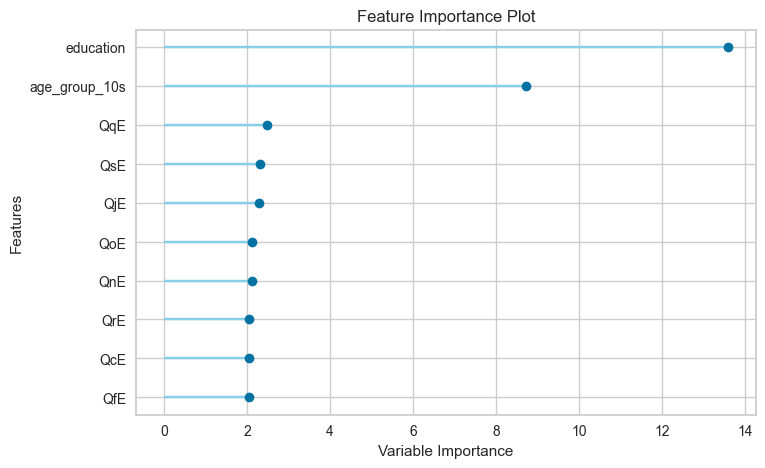

                                    Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.6915  0.7635  0.6568  0.7483   
gbc          Gradient Boosting Classifier    0.6915  0.7631  0.6404  0.7580   
lightgbm  Light Gradient Boosting Machine    0.6917  0.7611  0.6416  0.7576   
ada                  Ada Boost Classifier    0.6885  0.7557  0.6469  0.7492   
et                 Extra Trees Classifier    0.6859  0.7547  0.6315  0.7542   
ridge                    Ridge Classifier    0.6864  0.7533  0.6475  0.7455   
lda          Linear Discriminant Analysis    0.6866  0.7533  0.6472  0.7460   
rf               Random Forest Classifier    0.6857  0.7517  0.6284  0.7558   
xgboost         Extreme Gradient Boosting    0.6727  0.7404  0.6643  0.7166   
qda       Quadratic Discriminant Analysis    0.4713  0.6934  0.0569  0.6455   
lr                    Logistic Regression    0.5576  0.6076  0.9462  0.5588   
dt               Decision Tree Classifier    0.6097 

In [13]:
best_model = compare_models(sort='AUC', n_select=1)

# Feature Importance 시각화
plot_model(best_model, plot='feature')

In [ ]:
# 파이프라인을 통과한 최종 피처 이름 직접 추출
# PyCaret의 파이프라인 마지막 단계(모델 제외)를 거친 데이터의 컬럼명을 가져옵니다.
final_pipeline = get_config('pipeline')
X_transformed = final_pipeline.transform(train.drop(['voted', 'index'], axis=1))
feature_names = X_transformed.columns.tolist()

# 중요도 매칭 및 출력
feature_importances = best_model.feature_importances_

if len(feature_names) == len(feature_importances):
    ft_importance = pd.DataFrame({
        'Feature': feature_names, 
        'Importance': feature_importances
    })
    ft_importance = ft_importance.sort_values(by='Importance', ascending=False)
    
    print("--- 최종 피처 중요도 상위 100개 ---")
    print(ft_importance.head(100))
else:
    # 개수가 여전히 다를 경우 (모델이 자체적으로 피처를 요약했을 때)
    print(f"매칭 실패: 피처명 {len(feature_names)}개 / 중요도 {len(feature_importances)}개")
    # 이 경우 모델이 제공하는 내장 함수를 사용
    print("모델 내장 피처 리스트를 시도합니다...")
    ft_importance = pd.DataFrame({
        'Feature': best_model.feature_names_, 
        'Importance': best_model.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print(ft_importance.head(50))

--- 최종 피처 중요도 상위 50개 ---
                          Feature  Importance
47                      education   13.573719
40                  age_group_10s    8.712953
33                            QqE    2.474982
37                            QsE    2.310660
19                            QjE    2.275922
29                            QoE    2.118500
27                            QnE    2.114734
35                            QrE    2.055475
5                             QcE    2.050675
11                            QfE    2.042342
23                            QlE    2.025719
3                             QbE    1.984849
1                             QaE    1.958785
39                            QtE    1.932613
31                            QpE    1.927769
13                            QgE    1.842817
55                     race_White    1.840983
52                        married    1.830887
17                            QiE    1.824504
25                            QmE    1.820915
15       

In [ ]:
'''

# AutoML 결과를 바탕으로 선별한 피처 리스트
FEATURES_TO_USE = [
    # 인구통계 및 환경
    'education', 'age_group', 'race', 'married', 'familysize', 'engnat', 'gender', 'religion', 'urban',
    # 답변 시간 (상위권 위주 혹은 전체) - Log 변환 대상, cliping도 고려해야함 (이상치 정리용으로 1%가 적당해보임)
    'QaE', 'QbE', 'QcE', 'QdE', 'QeE', 'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
    'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 'QpE', 'QqE', 'QrE', 'QsE', 'QtE',
    # 성향 (tp)
    'tp01', 'tp02', 'tp03', 'tp04', 'tp05', 'tp06', 'tp07', 'tp08', 'tp09', 'tp10',
    # 질문 답변 (상위권 위주)
    'QcA', 'QrA', 'QqA', 'QpA', 'QeA', 'QdA', 'QtA', 'QjA', 'QfA', 'QhA'
]

# 단어 인지(wr, wf)는 중요도가 낮으므로 합계(score)만 파생변수

'''